In [59]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bnlcrl.pkcli.simulate
from scipy.signal import find_peaks_cwt
%matplotlib inline

# Calculate spectrum and select the 5th harmonic
### Data from https://expdev.nsls2.bnl.gov/srw#/source/blSqHnE5:

In [48]:
%run -i chx_spectrum.py

In [49]:
und_by = 0.6
res_file = 'res_spectrum_und_by_{}.dat'.format(und_by)
kwargs = {
    'und_by': und_by,
    'ss_fn': res_file,
}
chx_spectrum(**kwargs)

Single-electron SR calculation ... completed (lasted 1.154294 s)
Extracting intensity and saving it to a file ... completed (lasted 0.006456 s)


In [50]:
!ls -al

total 384
drwxr-xr-x  3 mrakitin mrakitin   4096 Dec  3 00:04 .
drwxr-xr-x 13 mrakitin mrakitin   4096 Dec  2 15:46 ..
-rw-rw-r--  1 mrakitin mrakitin  18706 Dec  2 23:58 chx_spectrum.py
-rw-r--r--  1 mrakitin mrakitin  28672 Dec  2 23:58 .chx_spectrum.py.swp
drwxr-xr-x  2 mrakitin mrakitin   4096 Dec  2 15:48 .ipynb_checkpoints
-rw-r--r--  1 mrakitin mrakitin 151197 Dec  2 23:57 res_spec_se.dat
-rw-r--r--  1 mrakitin mrakitin 151197 Dec  3 00:05 res_spectrum_und_by_0.6.dat
-rw-r--r--  1 mrakitin mrakitin  27237 Dec  3 00:04 srw_peaks.ipynb


In [51]:
!cat {res_file} | head -15

# [ph/s/.1%bw/mm^2] (C-aligned, inner loop is vs Photon Energy, outer loop vs Vertical Position)
#10.0 #Initial Photon Energy [eV]
#20000.0 #Final Photon Energy [eV]
#10000 #Number of points vs Photon Energy
#0.0 #Initial Horizontal Position [m]
#0.0 #Final Horizontal Position [m]
#1 #Number of points vs Horizontal Position
#0.0 #Initial Vertical Position [m]
#0.0 #Final Vertical Position [m]
#1 #Number of points vs Vertical Position
 141.51602172851562
 212.7181854248047
 192.0355224609375
 65.62773895263672
 27.26546287536621
cat: write error: Broken pipe


In [52]:
x_min = None
x_max = None
num = None
with open(res_file) as f:
    for i in range(10):
        r = f.readline()
        if re.search('Initial Photon Energy', r):
            x_min = float(r.split('#')[1].strip())
        if re.search('Final Photon Energy', r):
            x_max = float(r.split('#')[1].strip())
        if re.search('Number of points vs Photon Energy', r):
            num = int(r.split('#')[1].strip())

In [53]:
x_values = np.linspace(x_min, x_max, num)
x_values.shape

(10000,)

In [54]:
y_values = np.loadtxt(res_file)
y_values.shape

(10000,)

In [55]:
df = pd.DataFrame({'x_values': x_values, 'y_values': y_values})

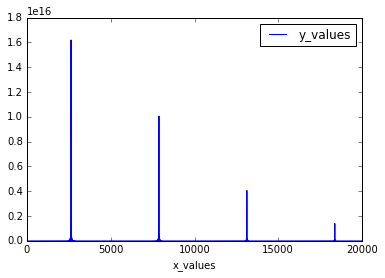

In [56]:
df.plot(x='x_values', y='y_values')

### https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.find_peaks_cwt.html
### https://stackoverflow.com/a/25580682

x: 2626.95269527    ymax: 1.57767323594e+16
x: 7876.85168517    ymax: 1.00637816107e+16
x: 13126.7506751    ymax: 4.06444995877e+15
x: 18378.6488649    ymax: 1.37524987036e+15


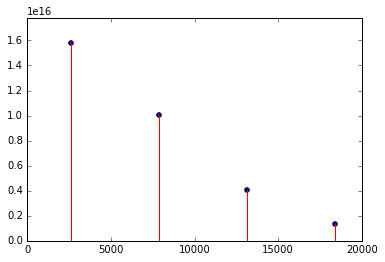

In [57]:
plt.figure()
idx = find_peaks_cwt(df['y_values'], np.arange(1, 30), noise_perc=0.1)
plt.scatter(df['x_values'][idx], df['y_values'][idx])
plt.xlim (0, x_max)
plt.ylim (0, 1.1*y_values.max())
for i in idx:
    print('x: {}    ymax: {}'.format(df['x_values'][i], df['y_values'][i]))
    plt.vlines(x=df['x_values'][i], ymin=0, ymax=df['y_values'][i], color='red')

In [69]:
# 5th harmonic:
harm5_idx = idx[2]
energy_harm5 = df['x_values'][harm5_idx]
intensity_harm5 = df['y_values'][harm5_idx]
print('''
    Harmonic index: {}
    Energy        : {}
    Intensity     : {}
'''.format(harm5_idx, energy_harm5, intensity_harm5))


    Harmonic index: 6561
    Energy        : 13126.7506751
    Intensity     : 4.06444995877e+15



# Find refractive index decrement and attenuation length for found energy
### Index of refraction:

In [70]:
bnlcrl.pkcli.simulate.find_delta(energy=energy_harm5, formula='Be', characteristic='delta')

{'characteristic': 'delta',
 'characteristic_value': 1.99297915e-06,
 'closest_energy': 13073.7412,
 'element': 'Be',
 'method': 'server'}

In [71]:
bnlcrl.pkcli.simulate.find_delta(energy=energy_harm5, formula='Be', characteristic='delta', data_file='Be_delta.dat')

{'characteristic': 'delta',
 'characteristic_value': 1.97677696e-06,
 'closest_energy': 13127.1846,
 'element': 'Be',
 'method': 'file'}

### Attenuation length:

In [72]:
bnlcrl.pkcli.simulate.find_delta(energy=energy_harm5, formula='Be', characteristic='atten')

{'characteristic': 'atten',
 'characteristic_value': 0.017097599999999998,
 'closest_energy': 13095.5,
 'element': 'Be',
 'method': 'server'}

In [73]:
bnlcrl.pkcli.simulate.find_delta(energy=energy_harm5, formula='Be', characteristic='atten', data_file='Be_atten.dat')

{'characteristic': 'atten',
 'characteristic_value': 0.017178799999999998,
 'closest_energy': 13130.7,
 'element': 'Be',
 'method': 'file'}

# Insert the found energy and material parameters to intensity calculation with wavefront propagation

In [74]:
%run -i chx_intensity_prop.py

ERROR:root:File `u'chx_intensity_prop.py'` not found.
